# ANNDL CHALLENGE 2

## Set up envoironment

### Set up Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/ANNDL/Challenge2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1wYXyoEwRqU1umxccIJJH4SamZKzkPV7x/ANNDL/Challenge2


### Import libraries

In [ ]:
import sys
sys.path.append('Federico') 

In [ ]:
from utils import augmentation as aug
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data loading

In [ ]:
#Data loading
x = np.load('/gdrive/MyDrive/ANNDL/Challenge2/training_dataset_homework2/x_train.npy')
y = np.load('/gdrive/MyDrive/ANNDL/Challenge2/training_dataset_homework2/y_train.npy')

In [ ]:
#Dimension of the data 
print('n =', x.shape[0], ' timestamps =', x.shape[1], 'features =', x.shape[2])

n = 2429  timestamps = 36 features = 6


###Inspect the dataset

In [ ]:
from collections import Counter
Counter(y)

Counter({0: 34,
         1: 123,
         2: 270,
         3: 381,
         4: 62,
         5: 153,
         6: 313,
         7: 68,
         8: 120,
         9: 777,
         10: 77,
         11: 51})

In [ ]:
grade_distribution_y = {'0': x[:,35,0],'1': x[:,35,1],'2': x[:,35,2],'3': x[:,35,3],'4': x[:,35,4],'5': x[:,35,5],
                        'classes': y }   
df_y = pd.DataFrame(grade_distribution_y, columns = ['0','1','2','3','4','5','classes'])
print(df_y)

             0        1         2          3          4          5  classes
0     43.71900  30.6890  950.9200  859.27000  8133.1000  988.83000        0
1     -4.63520  -3.2769   -5.9048   -0.19564     1.1487   23.27500        0
2     12.55700   2.2734    4.4831  -12.88500    10.4880  -66.96000        0
3      4.48520   2.4419   -2.2354   -0.31232    -5.0553  -32.70000        0
4     -1.68130  40.5160  -72.2560 -122.61000    20.3510  -87.72900        0
...        ...      ...       ...        ...        ...        ...      ...
2424 -16.19600   7.4568   19.1400   21.01600    31.0340   78.30600       11
2425   4.62530   1.0230    4.1203    2.52420    30.1710   30.37800       11
2426  -0.72203   2.8672    6.6811   13.44000    17.8740   27.19300       11
2427   5.93960   2.3820   13.2110   18.60300    33.1230    0.44679       11
2428  -1.55450  -1.2121    1.0705    1.32720     2.4010    8.45500       11

[2429 rows x 7 columns]


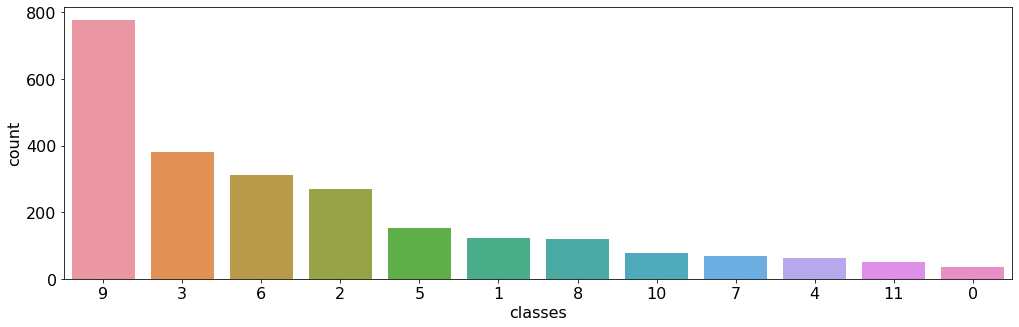

In [ ]:
# Inspect classes  
plt.figure(figsize=(17,5))
sns.countplot(x = 'classes', data = df_y, order = df_y.classes.value_counts().index)
plt.show()

In [ ]:
#create a dataframe for each n
def create_df(n):
  grade_distribution_0 = {'0': x[n,:,0],'1': x[n,:,1],'2': x[n,:,2],'3': x[n,:,3],'4': x[n,:,4],'5': x[n,:,5]}
        #'classes': y }   
  df = pd.DataFrame(grade_distribution_0, columns = ['0','1','2','3','4','5'])
  return df

In [ ]:
def inspect_activity(df):     #(classes, df):
    data = df[['0','1','2','3','4','5']][:100]
    axis = data.plot(subplots=True, figsize=(17, 9)) # title=classes)
    for ax in axis:
        ax.legend(loc='lower right')

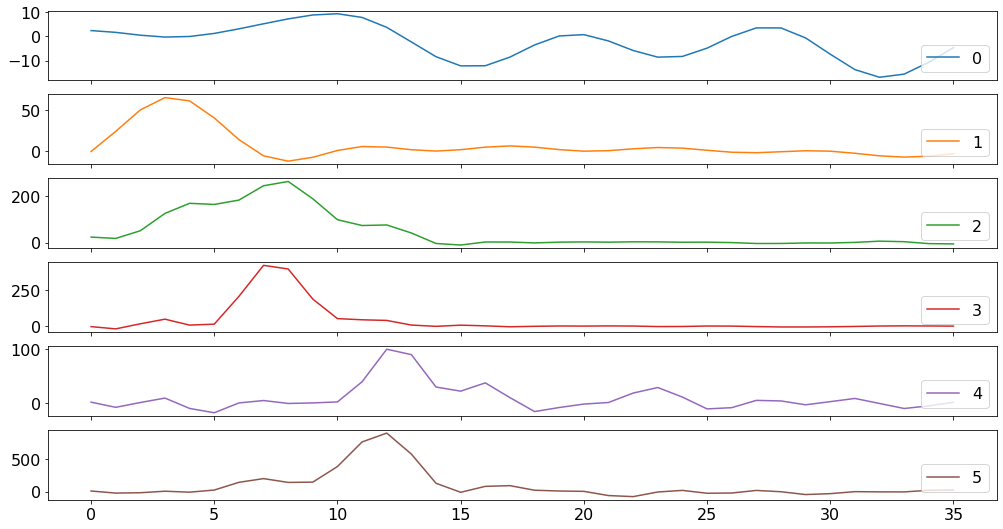

In [ ]:
inspect_activity(create_df(1)) #timeseries at n = 1

## Train test split

In [ ]:
# Split the dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
#Data augmentation using an external library 
x_train = np.append(x_train, aug.random_guided_warp(x_train, y_train), axis=0)
y_train = np.append(y_train, y_train, axis=0)

print(x_train.shape)
print(y_train.shape)

# Shuffle the indexes
x_train, y_train = shuffle(x_train, y_train)

100%|██████████| 1943/1943 [00:02<00:00, 734.67it/s]

(3886, 36, 6)
(3886,)


In [ ]:
# Data augmentation: shift the order of timestamps in each sample and add a random noise

N = x_train.shape[0]        # Number of samples
T = x_train.shape[1]        # Number of timestamps
F = x_train.shape[2]        # Number of features

new_train_1 = np.zeros((N, T, F))   
step = int(T/2)

for i in np.arange(0,N):
  for j in range(0,F): 
    
    new_train_1[i,0:step,j] = x_train[i,-step:,j] + np.random.standard_normal(step)
    new_train_1[i,-step:,j] = x_train[i,0:step,j] + np.random.standard_normal(step)

x_newtrain = np.zeros((2*N, T, F))
x_newtrain[0:N,:,:] = x_train
x_newtrain[N:2*N,:,:] = new_train_1
x_newtrain.shape


(7772, 36, 6)

In [ ]:
#Append the new labels on the dataset
y_newtrain = np.zeros(2*y_train.shape[0])
y_newtrain[0:y_train.shape[0]] = y_train
y_newtrain[y_train.shape[0]:2*y_train.shape[0]] = y_train
y_newtrain.shape

(7772,)

In [ ]:
x_train = x_newtrain
y_train = y_newtrain

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

###Correlation between the features

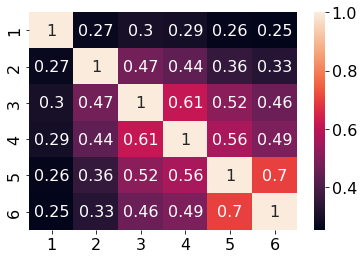

In [ ]:
A = x.copy()

names = ['x', 'y', 'z']

index = pd.MultiIndex.from_product([range(s)for s in A.shape], names=names)
df = pd.DataFrame({'A': A.flatten()}, index=index)['A']
df = df.unstack(level='z').swaplevel().sort_index()

columns = []

for i in range(6):
  columns.append(str(i+1))

df.columns = columns
df.index.names = ['Second', 'i']

sns.heatmap(df.corr(), annot=True)
plt.show()

### Parameters

In [ ]:
# Set the parameters
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 192
epochs = 600
print('epochs =', epochs, ' batch_size =', batch_size, 'classes =', classes)

epochs = 600  batch_size = 192 classes = 12


###Build and train the model 





In [ ]:
def model_1D_CNN(input_shape, classes):
    # Build the neural network layer by layer

    input_layer = tfkl.Input(shape=input_shape, name='Input')
  
    # Feature extractor
    cnn_1 = tfkl.Conv1D(128,2,padding='same',activation='relu')(input_layer)  
    cnn_2 = tfkl.AveragePooling1D(name = 'AveragePooling1D_1')(cnn_1)
    dropout = tfkl.Dropout(.2, seed=seed)(cnn_2)
    cnn_3 = tfkl.Conv1D(256,2,padding='same',activation='relu')(dropout)       
    cnn_4 = tfkl.AveragePooling1D()(cnn_3)
    dropout = tfkl.Dropout(.2, seed=seed)(cnn_4)
    cnn_5 = tfkl.Conv1D(512,2,padding='same',activation='relu')(dropout)
    gap = tfkl.GlobalAveragePooling1D()(cnn_5)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01))(dropout)   # Add a L2 regularization term with lambda = 0.01
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


In [ ]:
#Summary of the model
model = model_1D_CNN(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 36, 128)           1664      
                                                                 
 AveragePooling1D_1 (Average  (None, 18, 128)          0         
 Pooling1D)                                                      
                                                                 
 dropout_18 (Dropout)        (None, 18, 128)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 18, 256)           65792     
                                                                 
 average_pooling1d_12 (Avera  (None, 9, 256)           0         
 gePooling1D)                                                

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 192, 
    epochs = epochs,
    validation_split=.3,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.2, min_lr=1e-6)
    ]
).history

Epoch 1/600
29/29 [==============================] - 1s 18ms/step - loss: 11.0921 - accuracy: 0.1842 - val_loss: 5.5736 - val_accuracy: 0.2719 - lr: 0.0010
Epoch 2/600
29/29 [==============================] - 0s 10ms/step - loss: 5.3412 - accuracy: 0.3928 - val_loss: 4.9348 - val_accuracy: 0.4322 - lr: 0.0010
Epoch 3/600
29/29 [==============================] - 0s 9ms/step - loss: 4.7688 - accuracy: 0.4349 - val_loss: 4.4833 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 4/600
29/29 [==============================] - 0s 8ms/step - loss: 4.3819 - accuracy: 0.4688 - val_loss: 4.1351 - val_accuracy: 0.4794 - lr: 0.0010
Epoch 5/600
29/29 [==============================] - 0s 8ms/step - loss: 4.2079 - accuracy: 0.4803 - val_loss: 3.8869 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 6/600
29/29 [==============================] - 0s 9ms/step - loss: 3.9716 - accuracy: 0.4798 - val_loss: 3.6410 - val_accuracy: 0.5124 - lr: 0.0010
Epoch 7/600
29/29 [==============================] - 0s 9ms/step - loss: 

In [ ]:
# Save the model
model.save('model_1D_CNN')

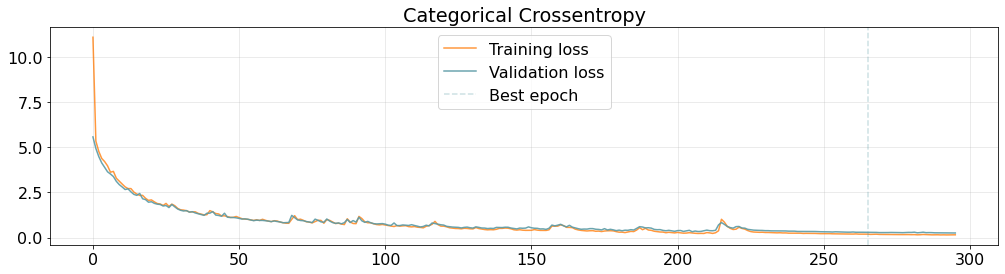

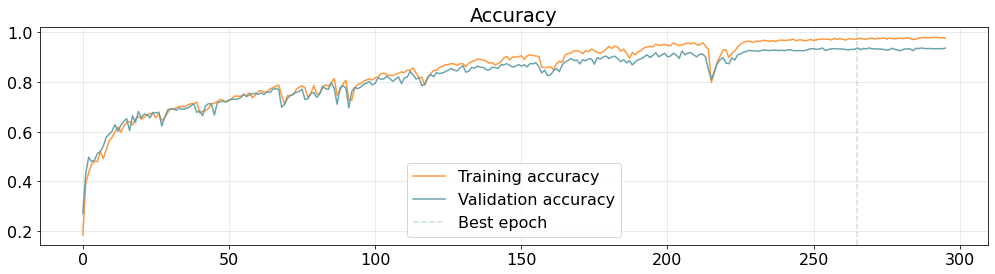

In [ ]:
#Plot the history of the losses: training vs validation
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#Plot the history of the accuracy: training vs validation
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


In [ ]:
# Prediction of the labels on the test set and accuracy
predictions = model.predict(x_test)
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
print(accuracy)

16/16 [==============================] - 0s 3ms/step
0.7407407407407407


Accuracy: 0.7407
Precision: 0.7267
Recall: 0.6655
F1: 0.6866


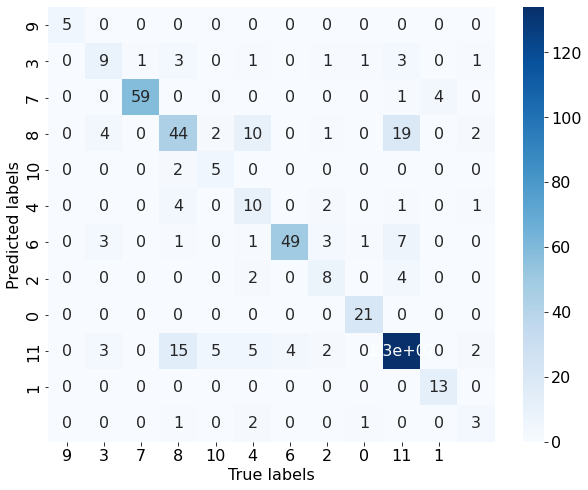

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels={"0","1","2","3","4","6","7","8","9","10","11"}, yticklabels={"0","1","2","3","4","6","7","8","9","10","11"},annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
